# Install and Import Dependencies

In [49]:
!pip install openpyxl

   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   --------------------------------------- 250.9/250.9 kB 16.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import unicodedata
import nltk
from nltk.corpus import stopwords
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import openpyxl

c:\Users\Arthur Coutinho Sant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Load data

The dataset for this project will be obtained through web scraping from the official IMDB website.

## Web Crawling settings

In [4]:
# Configure Selenium to run in headless mode (without graphical interface)
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Set the User-Agent to simulate a real browser
chrome_options.add_argument(
    "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
)
chrome_options.add_argument("--lang=en-US")


# Initialize the browser
driver = webdriver.Chrome(options=chrome_options)

# Access IMDB page
url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'
driver.get(url)

time.sleep(10)

# Obtain the HTML rendered by Selenium
html = driver.page_source

headers = {
    'authority': 'www.amazon.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'en-US,en;q=0.9,pt;q=0.8',
    'cache-control': 'max-age=0',
    'device-memory': '8',
    'downlink': '10',
    'dpr': '1.875',
    'ect': '4g',
    'rtt': '50',
    'sec-ch-device-memory': '8',
    'sec-ch-dpr': '1.875',
    'sec-ch-ua': '"Chromium";v="110", "Not A(Brand";v="24", "Google Chrome";v="110"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-ch-ua-platform-version': '"10.0.0"',
    'sec-ch-viewport-width': '455',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'none',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36',
    'viewport-width': '455',
}

In [5]:
bs = BeautifulSoup(html)

### Extracting data (Genre, Title, Year, Synopsis and Rating)

In [6]:
list_rating = []

# Step 3: Locate the relevant element
rating_span = bs.find_all('span', class_='ipc-rating-star--rating')
for x in rating_span:
  list_rating.append(x.text)

print(len(list_rating))

250


In [7]:
list_links = []
# Find all <a> elements with the href attribute.
for a in bs.find_all('a', href=True):
    href = a['href']
    
    # Check if the link contains '/title/' and follows the specific format 'ref_=chttp_t_'.
    if '/title/' in href and 'ref_=chttp_t_' in href:
        # Build the complete url
        full_link = 'https://www.imdb.com' + href
        
        if full_link not in list_links:
            list_links.append(full_link)

# Drop duplicates
list_links = list(dict.fromkeys(list_links))

print(len(list_links))

250


In [10]:
list_genre = []
list_title_en = []
list_year = []
list_synopsis = []
list_images = []

for link in list_links:
    time.sleep(.5)
    response = requests.get(link, headers=headers)
    html = response.content
    soup = BeautifulSoup(html, "html.parser")

    # Genre
    try:
        for genre in soup.find('span', {'class': 'ipc-chip__text'}):
            genre = genre.text
            list_genre.append(genre)
    except:
        list_genre.append(np.nan)
        print('Nan')

    # Title_EN and Year
    try:
        for x in soup.find('title'):
            # Title_EN
            title_en = (x.text)[:-14].strip()
            list_title_en.append(title_en)
            
            # Year
            year = (x.text)[-12:-8].strip()
            list_year.append(year)

    except:
        list_title_en.append(np.nan)
        list_year.append(np.nan)

    # Synopsis
    try:
        for sin in soup.find('span', {"data-testid": "plot-xl"}):
            synopsis = sin.text
            list_synopsis.append(synopsis)
    except:
        list_synopsis.append(np.nan)
    
    # Ajuste na parte de captura da URL da imagem
    try:
        # Carrega a mesma página com Selenium para garantir que a URL da imagem seja capturada corretamente
        driver.get(link)
        time.sleep(2)  # Aguarde a página carregar completamente
        
        # Usando o seletor CSS para localizar a imagem de capa
        image_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, '.ipc-media--poster-l > img'))
        )
        
        # Extrai o atributo 'src' que contém o link da imagem
        image_url = image_element.get_attribute('src')
    except Exception as e:
        print(f"Erro ao carregar a imagem: {e}")
        image_url = np.nan

    # Armazena o link da imagem na lista
    list_images.append(image_url)

    print('Genre:', genre, 'Title:', title_en, 'Year:', year, 'Synopsis:', synopsis[:20], 'Image:', image_url)


Genre: Epic Title: The Shawshank Redemption Year: 1994 Synopsis: A banker convicted o Image: https://m.media-amazon.com/images/M/MV5BMDAyY2FhYjctNDc5OS00MDNlLThiMGUtY2UxYWVkNGY2ZjljXkEyXkFqcGc@._V1_QL75_UX190_CR0,2,190,281_.jpg
Genre: Epic Title: The Godfather Year: 1972 Synopsis: The aging patriarch  Image: https://m.media-amazon.com/images/M/MV5BYTJkNGQyZDgtZDQ0NC00MDM0LWEzZWQtYzUzZDEwMDljZWNjXkEyXkFqcGc@._V1_QL75_UY281_CR4,0,190,281_.jpg
Genre: Action Epic Title: The Dark Knight Year: 2008 Synopsis: When a menace known  Image: https://m.media-amazon.com/images/M/MV5BMTMxNTMwODM0NF5BMl5BanBnXkFtZTcwODAyMTk2Mw@@._V1_QL75_UX190_CR0,0,190,281_.jpg
Genre: Epic Title: The Godfather Part II Year: 1974 Synopsis: The early life and c Image: https://m.media-amazon.com/images/M/MV5BNzc1OWY5MjktZDllMi00ZDEzLWEwMGItYjk1YmRhYjBjNTVlXkEyXkFqcGc@._V1_QL75_UY281_CR4,0,190,281_.jpg
Genre: Legal Drama Title: 12 Angry Men Year: 1957 Synopsis: The jury in a New Yo Image: https://m.media-amazon.com/image

# Descriptive Analysis

In [11]:
df = pd.DataFrame({'title_en':list_title_en,
                   'year':list_year,
                   'rating':list_rating,
                   'genre':list_genre,
                   'synopsis':list_synopsis,
                   'imgs': list_images})

df.sort_values('year', inplace = True)

print(df.shape)
df.head()

(250, 6)


,title_en,year,rating,genre,synopsis,imgs
133,The Kid,1921,8.2,Buddy Comedy,"The Tramp cares for an abandoned child, but ev...",https://m.media-amazon.com/images/M/MV5BNjkxMz...
199,Sherlock Jr.,1924,8.2,Bumbling Detective,"A film projectionist longs to be a detective, ...",https://m.media-amazon.com/images/M/MV5BMjQzM2...
194,The Gold Rush,1925,8.1,Farce,A prospector goes to the Klondike during the 1...,https://m.media-amazon.com/images/M/MV5BNGU1Nj...
198,The General,1926,8.1,Farce,After being rejected by the Confederate milita...,https://m.media-amazon.com/images/M/MV5BMTVhM2...
119,Metropolis,1927,8.3,Dystopian Sci-Fi,In a futuristic city sharply divided between t...,https://m.media-amazon.com/images/M/MV5BMjhjMG...


In [12]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df['rating'] = df['rating'].astype('float64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 133 to 44
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_en  250 non-null    object 
 1   year      250 non-null    int64  
 2   rating    250 non-null    float64
 3   genre     250 non-null    object 
 4   synopsis  250 non-null    object 
 5   imgs      250 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 13.7+ KB


In [26]:
df.describe()

,year,rating
count,250.000000,250.00000
mean,1987.576000,8.30960
std,25.562354,0.23368
min,1921.000000,8.00000
25%,1968.750000,8.10000
50%,1995.000000,8.20000
75%,2007.750000,8.40000
max,2024.000000,9.30000


# Exploratory Data Analysis

## Movies per genre

In [27]:
fig = px.bar(df['genre'].value_counts('d')*100,
             text_auto=True,
             title = '% of Movies per Genre',
             labels={'index':'Genre',
                     'value':'% of Movies'})
fig.show()

## Movies per Year

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



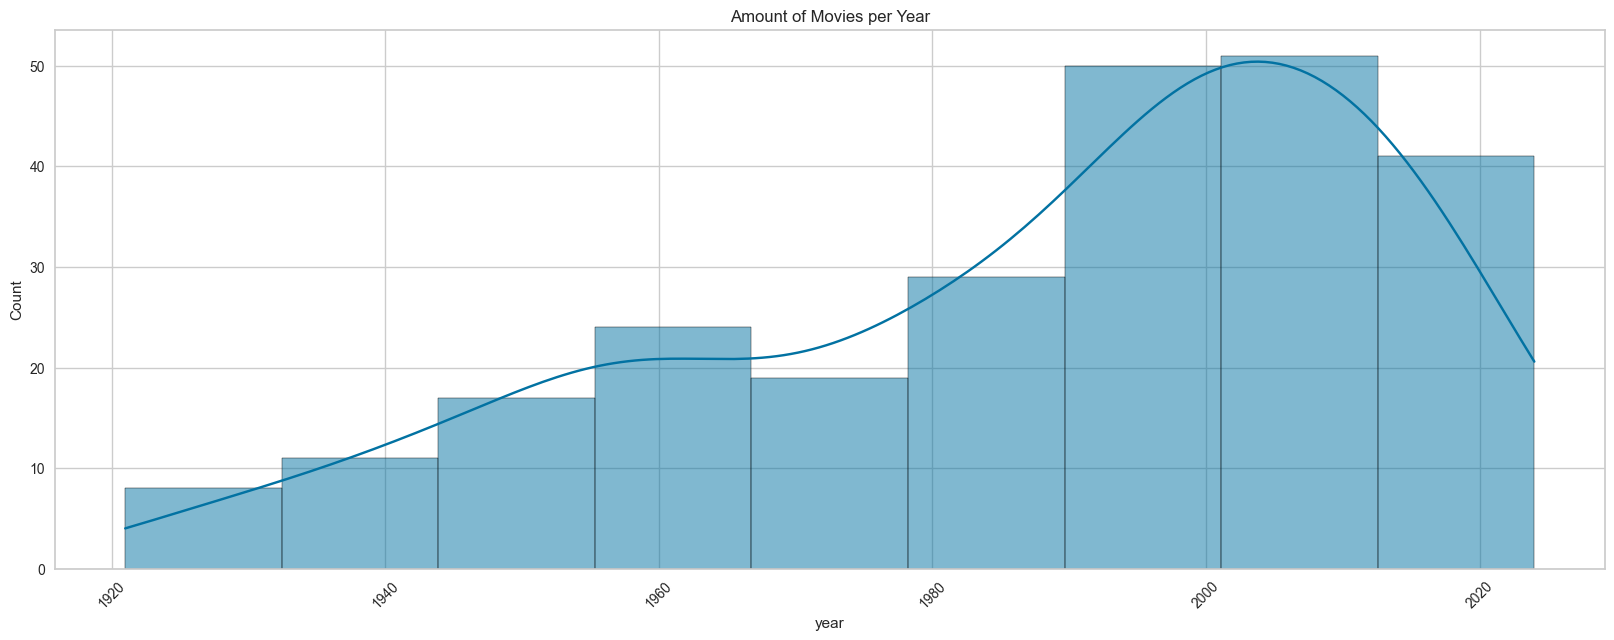

In [28]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True).set_title('Amount of Movies per Year')

plt.xticks(rotation=45)
plt.show()

## Movies per Year and Genre

In [29]:
genre_mapping = {
    'Buddy Comedy': 'Comedy',
    'Bumbling Detective': 'Comedy',
    'Farce': 'Comedy',
    'Dystopian Sci-Fi': 'Sci-Fi',
    'Legal Drama': 'Drama',
    'Feel-Good Romance': 'Romance',
    'Psychological Thriller': 'Thriller',
    'Road Trip': 'Adventure',
    'Slapstick': 'Comedy',
    'Epic': 'Drama',
    'Classic Musical': 'Musical',
    'Political Drama': 'Drama',
    'Dark Romance': 'Romance',
    'Parody': 'Comedy',
    'Drama': 'Drama',
    'Screwball Comedy': 'Comedy',
    'Film Noir': 'Thriller',
    'Tragedy': 'Drama',
    'Crime': 'Crime',
    'Showbiz Drama': 'Drama',
    'Psychological Drama': 'Drama',
    'Suspense Mystery': 'Mystery',
    'Action Epic': 'Action',
    'Jungle Adventure': 'Adventure',
    'Adventure Epic': 'Adventure',
    'Spy': 'Action',
    'Holiday Comedy': 'Comedy',
    'Psychological Horror': 'Horror',
    'One-Person Army Action': 'Action',
    'Period Drama': 'Drama',
    'Police Procedural': 'Drama',
    'Dark Comedy': 'Comedy',
    'Docudrama': 'Drama',
    'Desert Adventure': 'Adventure',
    'Prison Drama': 'Drama',
    'Supernatural Horror': 'Horror',
    'Caper': 'Crime',
    'Conspiracy Thriller': 'Thriller',
    'Sea Adventure': 'Adventure',
    'Adventure': 'Adventure',
    'Medical Drama': 'Drama',
    'Workplace Drama': 'Drama',
    'Boxing': 'Sport',
    'War Epic': 'Drama',
    'Cyberpunk': 'Sci-Fi',
    'Alien Invasion': 'Sci-Fi',
    'Artificial Intelligence': 'Sci-Fi',
    'Drug Crime': 'Crime',
    'Costume Drama': 'Drama',
    'Car Action': 'Action',
    'Samurai': 'Action',
    'Coming-of-Age': 'Drama',
    'Anime': 'Animation',
    'Adult Animation': 'Animation',
    'Gangster': 'Crime',
    'Dinosaur Adventure': 'Adventure',
    'Animal Adventure': 'Adventure',
    'Cop Drama': 'Drama',
    'Romantic Comedy': 'Romance',
    'High-Concept Comedy': 'Comedy',
    'Satire': 'Comedy',
    'Martial Arts': 'Action',
    'Computer Animation': 'Animation',
    'Political Thriller': 'Thriller',
    'Contemporary Western': 'Western',
    'Comedy': 'Comedy',
    'Dark Fantasy': 'Fantasy',
    'Erotic Thriller': 'Thriller',
    'Action': 'Action',
    'Space Sci-Fi': 'Sci-Fi',
    'Hand-Drawn Animation': 'Animation',
    'Biography': 'Drama',
    'Superhero': 'Action',
}

df['genre_grouped'] = df['genre'].map(genre_mapping)

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho

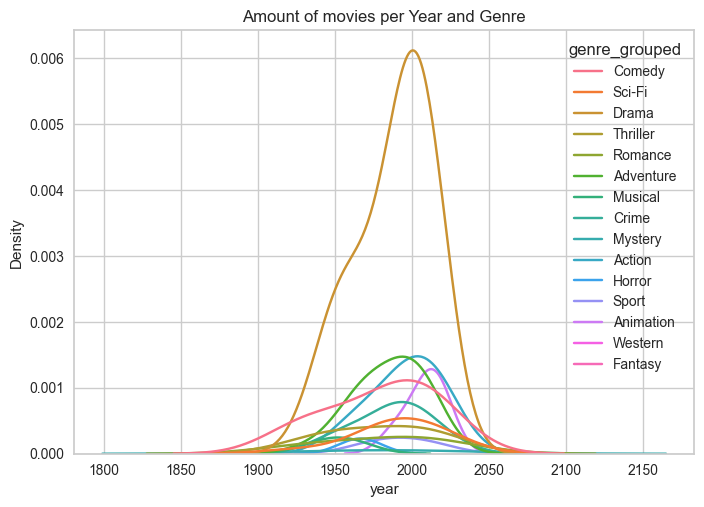

In [30]:
sns.kdeplot(df, x='year', hue='genre_grouped', bw_adjust=1.5, warn_singular=False).set_title('Amount of movies per Year and Genre')
plt.show()

# Pre-processing text

## Normalization NFD

Normalization ‘NFD’ (Normalization Form D) breaks down accented characters into their basic components. For example, the letter “á” is decomposed into “a” and the accent.

In this step, i also prefer to convert everything to lowercase.

In [13]:
def normalize_and_count(text):
    normalized_text = unicodedata.normalize('NFD', text).lower()
    return normalized_text, normalized_text != text

df['synopsis'], adjustments = zip(*df['synopsis'].apply(normalize_and_count))

adjustment_count = sum(adjustments)

print(f"Number of adjustments made: {adjustment_count}")

Number of adjustments made: 250


## Removing special characters

In [14]:
def encode_and_count(text):
    encoded_text = text.encode('ascii', 'ignore').decode('utf-8')
    return encoded_text, encoded_text != text

df['synopsis'], adjustments = zip(*df['synopsis'].apply(encode_and_count))

adjustment_count = sum(adjustments)

print(f"Number of adjustments made: {adjustment_count}")

Number of adjustments made: 2


## Removing stop-words

Stop words are words that, on their own, do not provide much meaning and are often ignored by search engines when indexing content. These words include articles, prepositions, conjunctions, and pronouns, among others. The goal of ignoring them is to focus on the most relevant keywords to enhance efficiency in searching and text analysis.

In [15]:
stop_words_en = stopwords.words('english')
df['synopsis'] = df['synopsis'].replace(to_replace=r'[,.!?\']', value='', regex=True)

print(f"{stop_words_en[0:5]}, etc.")

['i', 'me', 'my', 'myself', 'we'], etc.


In [16]:
df['synopsis'] = df['synopsis'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_en)]))

## Counting number of words

In [17]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [18]:
df['word_count'] = df['synopsis'].apply(qty_words).astype('int64')

# Word Cloud

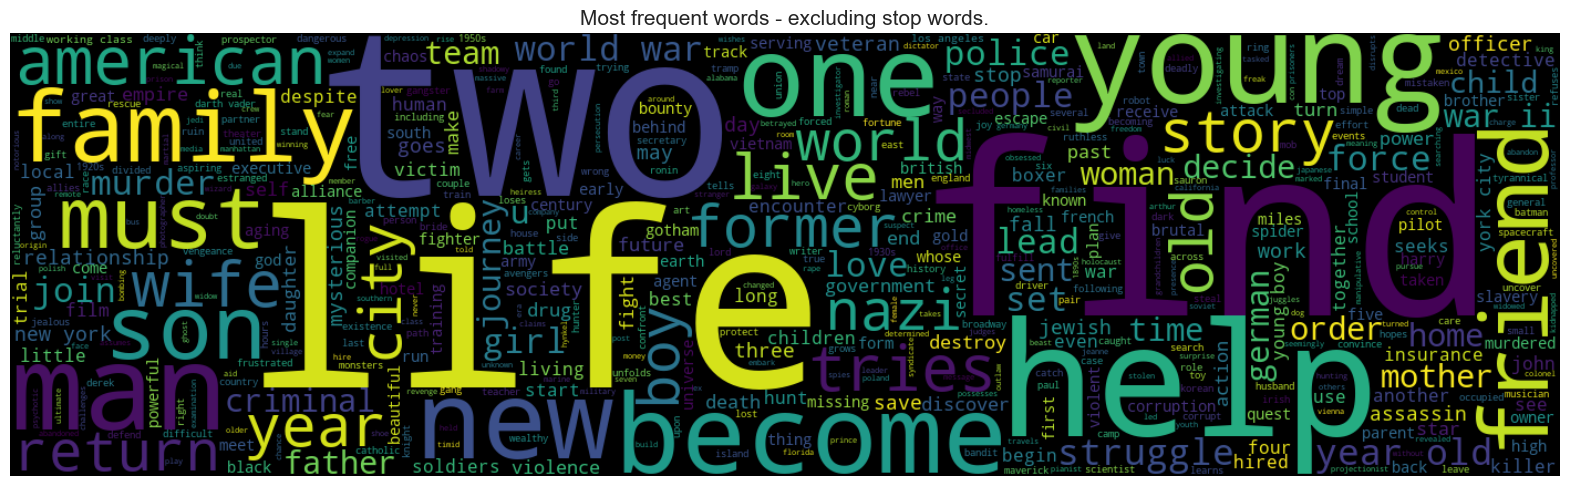

In [19]:
text = ' '.join([phrase for phrase in df['synopsis']])

plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1400, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words - excluding stop words.', fontsize = 15)
plt.show()

# Sentence Transformer Vectorization

Calculates a fixed-size vector representation (embedding) given texts or images. Embedding calculation is often efficient, embedding similarity calculation is very fast.

In [20]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
df['embeddings'] = df['synopsis'].apply(lambda x: model.encode(x))

c:\Users\Arthur Coutinho Sant\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Clusterization - Kmeans

In [21]:
X = np.vstack(df['embeddings'].values)

c:\Users\Arthur Coutinho Sant\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arthur Coutinho Sant\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


2 30098.625
3 28895.630859375
4 27931.37890625
5 27309.4140625
6 26798.451171875
7 26394.029296875
8 25916.87890625
9 25570.748046875
10 25370.09375
11 25243.4296875
12 24872.484375
13 24506.91796875
14 24389.208984375
15 24183.423828125
16 23872.2109375
17 23806.546875
18 23562.15234375
19 23372.06640625
20 23166.126953125
21 23025.0625
22 22707.66796875
23 22686.279296875
24 22306.14453125
25 22123.240234375
26 22175.84765625
27 22022.8203125
28 21705.267578125
29 21590.228515625
30 21389.37890625
31 21280.421875
32 21101.0
33 21071.224609375
34 20801.548828125
35 20711.68359375
36 20529.375
37 20246.37890625
38 20270.8203125
39 20088.556640625
40 19923.61328125
41 19877.533203125
42 19635.521484375
43 19604.98828125
44 19233.349609375
45 19163.111328125
46 19061.0
47 18944.3671875
48 18790.2734375
49 18474.337890625
50 18524.865234375
51 18300.587890625
52 18225.087890625
53 18044.54296875
54 17946.701171875
55 17874.724609375
56 17692.20703125
57 17413.34375
58 17521.978515625
59 1

Text(0, 0.5, 'WCSS')

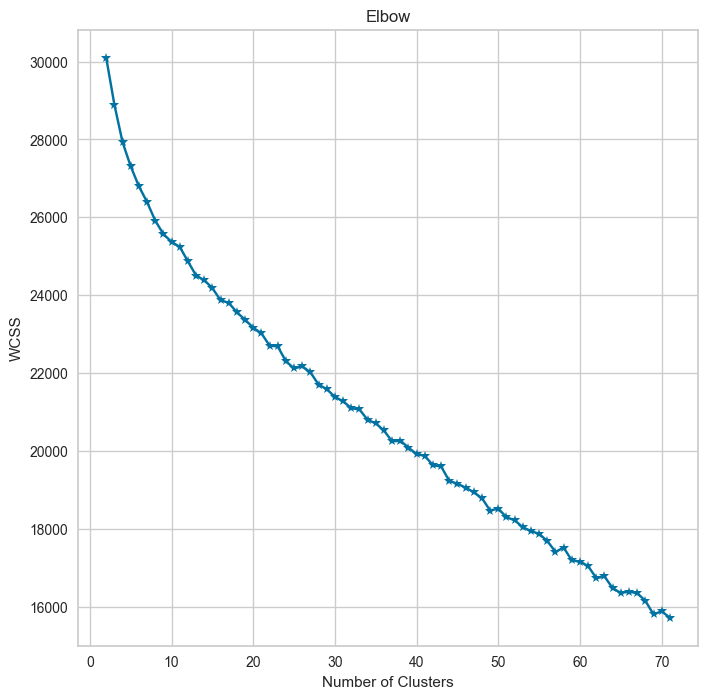

In [22]:
plt.figure(figsize = (8,8))

wcss = []

for i in range(2, df['genre'].nunique()+1):
  kmeans = KMeans(n_clusters = i, init = 'random')
  kmeans.fit(X)
  print(i, kmeans.inertia_)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, df['genre'].nunique()+1), wcss, '*-')
plt.title('Elbow')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS') #within cluster sum of square

A good number of clusters can be around 6 to 10 or 15 clusters. These numbers indicate reasonable inertia without becoming overly complex.

# Silhouette method

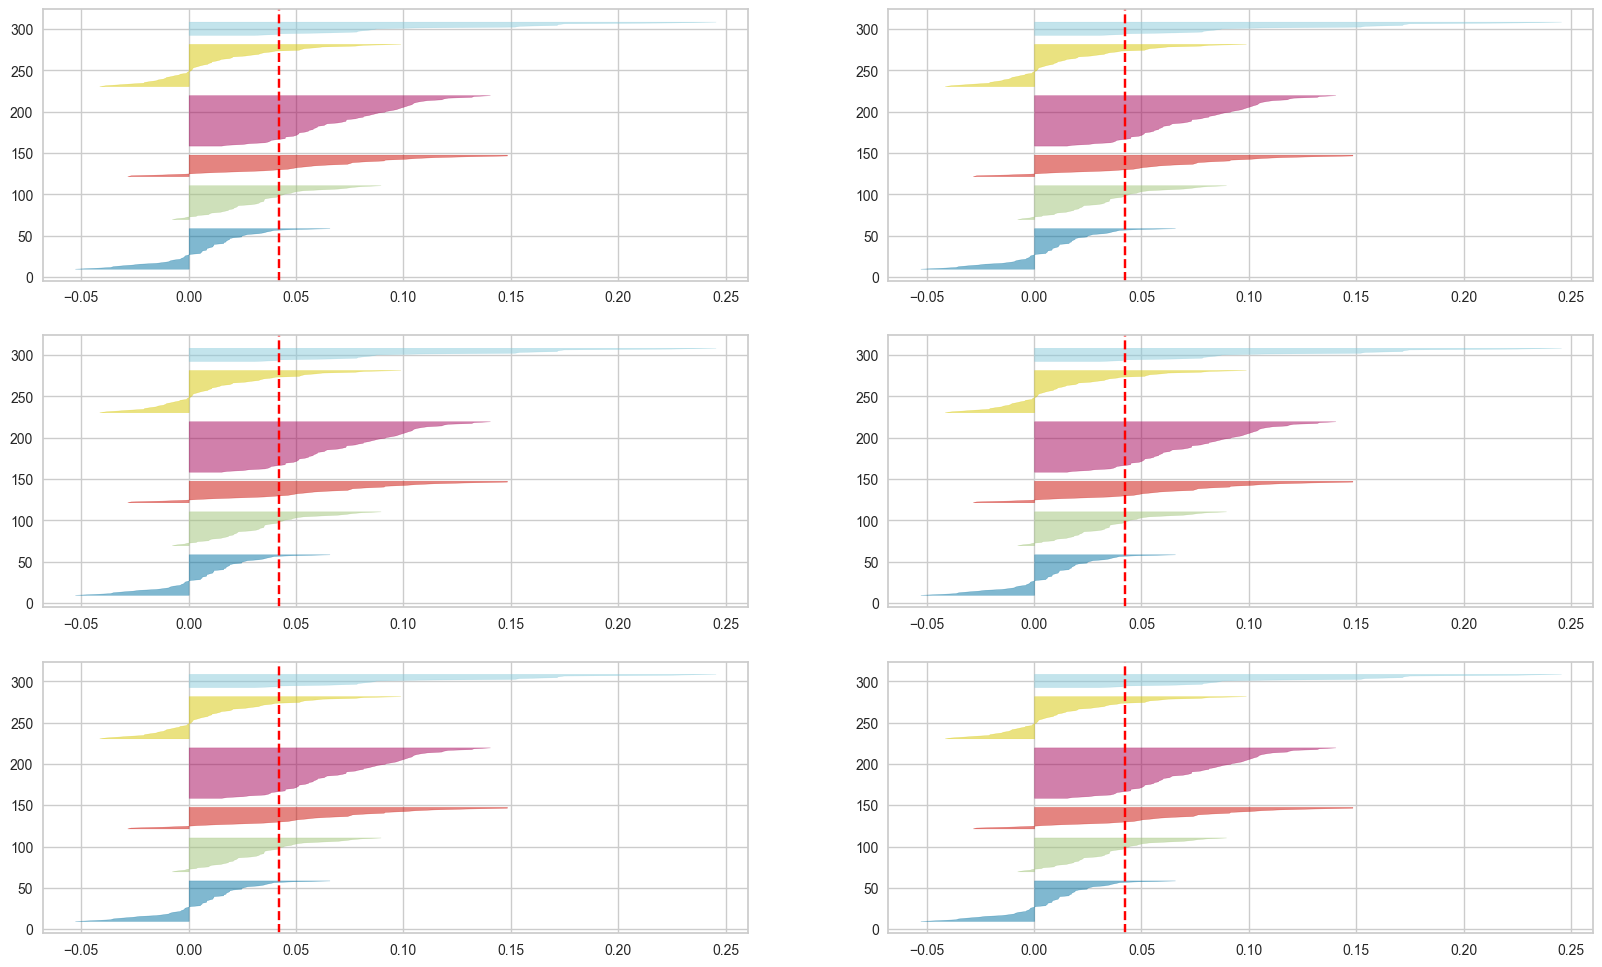

In [23]:
fig, ax = plt.subplots(3,2, figsize = (20,12))
for i in range(6):  # Adjusted loop to match the number of subplots
    #Creating KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters = 6, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)  # Calculate row and column indices

    #Creating SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer

    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q][mod])  # Access correct subplot
    visualizer.fit(X)

# Training model

In [24]:
# initialize kmeans with 5 centroids
kmeans = KMeans(n_clusters=6, random_state=42)

# fit the model
kmeans = kmeans.fit(X)

#predicting the clusters and store cluster labels in a variable
labels = kmeans.predict(X)

#getting the cluster centers
c = kmeans.cluster_centers_

df['cluster'] = labels
df.head()

,title_en,year,rating,genre,synopsis,imgs,word_count,embeddings,cluster
133,The Kid,1921,8.2,Buddy Comedy,tramp cares abandoned child events put relatio...,https://m.media-amazon.com/images/M/MV5BNjkxMz...,8,"[0.057974957, 0.35088265, 1.1779298, 0.5049269...",5
199,Sherlock Jr.,1924,8.2,Bumbling Detective,film projectionist longs detective puts meagre...,https://m.media-amazon.com/images/M/MV5BMjQzM2...,14,"[-0.37606168, 0.82281214, 0.590407, 0.4254718,...",5
194,The Gold Rush,1925,8.1,Farce,prospector goes klondike 1890s gold rush hopes...,https://m.media-amazon.com/images/M/MV5BNGU1Nj...,14,"[-0.2733932, 0.78396016, 0.099911444, 0.475015...",0
198,The General,1926,8.1,Farce,rejected confederate military realizing due cr...,https://m.media-amazon.com/images/M/MV5BMTVhM2...,20,"[-0.4499084, 0.81688875, 0.6432341, 0.8275297,...",4
119,Metropolis,1927,8.3,Dystopian Sci-Fi,futuristic city sharply divided working class ...,https://m.media-amazon.com/images/M/MV5BMjhjMG...,20,"[-0.34269467, 0.971742, 0.92792046, 0.11452935...",5


# Evaluation

## Movies per Cluster

In [25]:
fig = px.bar(df['cluster'].value_counts(),
             text_auto = True,
             title = 'Amount of Movies per Cluster',
             labels = {'index': 'Cluster',
                       'value':'Amount of Movies'})
fig.show()

## Year per Cluster

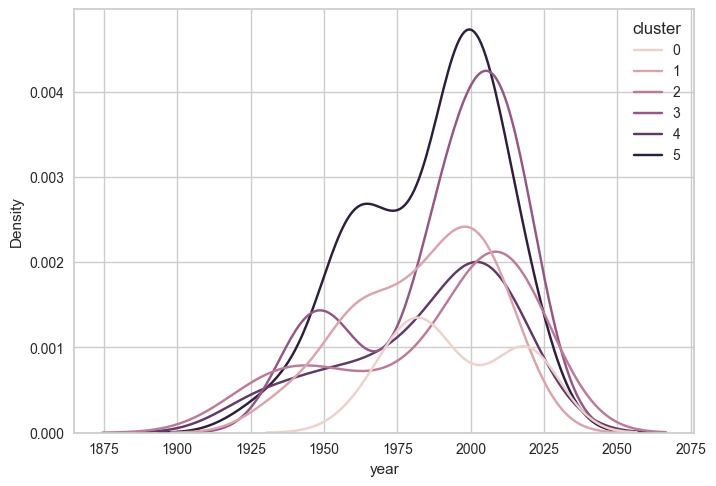

In [140]:
sns.kdeplot(df, x = 'year', hue = 'cluster');

## Genre per Cluster

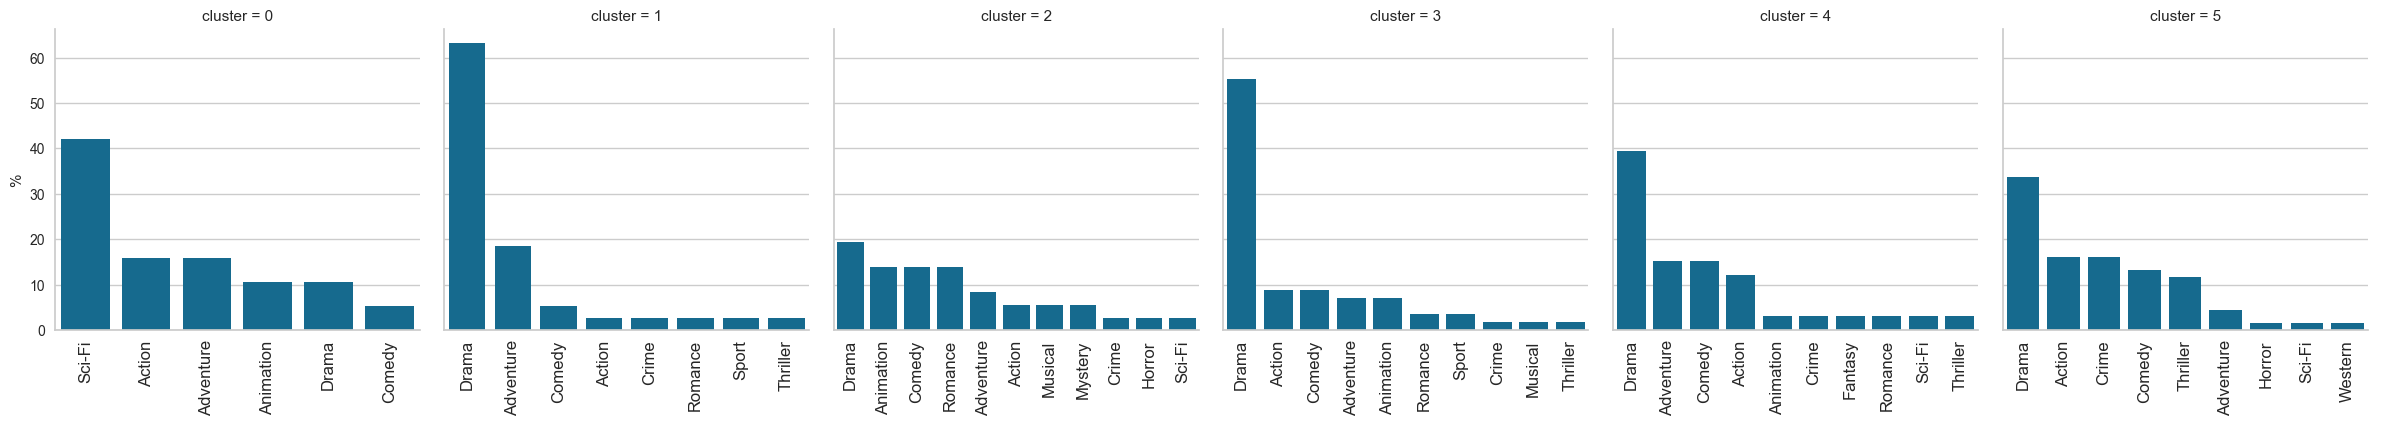

In [148]:
df_plot = df.groupby(['cluster', 'genre_grouped'])['title_en'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_en':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre_grouped", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 12);

# Save final dataset

In [27]:
df.to_excel('./deploy-streamlit/Xtest.xlsx', index=False)

# Validate

In [182]:
new_synopsis = "american car designer carroll shelby driver"

new_embedding = model.encode(new_synopsis)

Xtest = np.vstack(df['embeddings'].values)  # Certifique-se de que df['embeddings'] seja uma lista de arrays

similarities = cosine_similarity([new_embedding], Xtest)[0]  # Retorna um array com as similaridades

most_similar_index = similarities.argmax()  # Índice do maior valor de similaridade

target_cluster = df.iloc[most_similar_index]['cluster']

cluster_movies = df[df['cluster'] == target_cluster]

cluster_embeddings = np.vstack(cluster_movies['embeddings'].values)
cluster_similarities = cosine_similarity([new_embedding], cluster_embeddings)[0]

top_indices_in_cluster = cluster_similarities.argsort()[-5:][::-1]  # Índices dos 5 maiores valores, em ordem decrescente

recommended_movies = cluster_movies.iloc[top_indices_in_cluster]

recommended_movies[['title_en', 'cluster', 'synopsis']]

,title_en,cluster,synopsis
239,Ford v Ferrari,0,american car designer carroll shelby driver ke...
247,Oppenheimer,0,story american scientist j robert oppenheimer ...
87,Blade Runner,0,blade runner must pursue terminate four replic...
62,2001: A Space Odyssey,0,uncovering mysterious artifact buried beneath ...
86,The Thing,0,research team antarctica hunted shape-shifting...
